In [6]:
import os
import pandas as pd

# Define the root directory containing the subjects
root_dir = 'D:/Lomba/Current/Data Slayer 2.0/Train 2'  # Update this path as needed
data = []

# Supported image extensions
image_extensions = ('.jpg', '.jpeg', '.png')

# Walk through the directory structure
for subject in os.listdir(root_dir):
    subject_path = os.path.join(root_dir, subject)
    if os.path.isdir(subject_path):
        print(f"Processing subject: {subject}")  # Debugging line
        for label in os.listdir(subject_path):
            label_path = os.path.join(subject_path, label)
            if os.path.isdir(label_path):
                print(f"  Found label: {label}")  # Debugging line
                # Check if the label is 'fall' or 'non_fall'
                if label == 'fall':
                    # If it's a fall category, check subcategories
                    for category in os.listdir(label_path):
                        category_path = os.path.join(label_path, category)
                        if os.path.isdir(category_path):
                            print(f"    Processing fall category: {category}")  # Debugging line
                            for img_name in os.listdir(category_path):
                                if img_name.endswith(image_extensions):  # Check for image files
                                    img_path = os.path.join(category_path, img_name)
                                    data.append({'filename': img_path, 'label': 'fall'})
                elif label == 'non_fall':
                    # If it's a non-fall category, handle subcategories and direct images
                    print(f"  Processing non-fall category: {label}")  # Debugging line
                    for item in os.listdir(label_path):
                        item_path = os.path.join(label_path, item)
                        if os.path.isdir(item_path):  # Subcategories
                            print(f"    Processing non-fall subcategory: {item}")  # Debugging line
                            for img_name in os.listdir(item_path):
                                if img_name.endswith(image_extensions):  # Check for image files
                                    img_path = os.path.join(item_path, img_name)
                                    data.append({'filename': img_path, 'label': 'non_fall'})
                        elif item.endswith(image_extensions):  # Direct image files
                            img_path = os.path.join(label_path, item)
                            data.append({'filename': img_path, 'label': 'non_fall'})

# Create a DataFrame and save it to a CSV file
df = pd.DataFrame(data)
df.to_csv('image_labels 2.csv', index=False)

print("Labeling complete. CSV file created: image_labels 2.csv")


Processing subject: subject-1
  Found label: fall
    Processing fall category: 1_backward_falls
    Processing fall category: 1_forward_falls
    Processing fall category: 1_left_falls
    Processing fall category: 1_right_falls
    Processing fall category: 1_sitting_falls
    Processing fall category: 1_standing_falls
  Found label: non_fall
  Processing non-fall category: non_fall
    Processing non-fall subcategory: 1_jumping
    Processing non-fall subcategory: 1_laying
    Processing non-fall subcategory: 1_picking
    Processing non-fall subcategory: 1_squat
    Processing non-fall subcategory: 1_stretching
    Processing non-fall subcategory: 1_walking
Processing subject: subject-2
  Found label: fall
    Processing fall category: 2_backward_falls
    Processing fall category: 2_forward_falls
    Processing fall category: 2_left_falls
    Processing fall category: 2_right_falls
    Processing fall category: 2_sitting_falls
    Processing fall category: 2_standing_falls
  Found

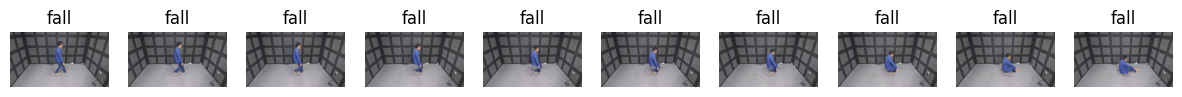

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Load the CSV file with image paths and labels
df = pd.read_csv('image_labels.csv')

# Function to display images
def show_images(df, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img_path = df['filename'].iloc[i]
        label = df['label'].iloc[i]
        
        # Load the image
        img = Image.open(img_path)
        
        # Display the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')  # Hide axes
    plt.show()

# Show the first 5 images
show_images(df, num_images=10)

In [13]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe['filename'].iloc[idx]
        label = self.dataframe['label'].iloc[idx]
        
        # Load the image
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Create dataset instances
train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [14]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load the CSV file with image paths and labels
df = pd.read_csv('image_labels 2.csv')

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
        # Initialize the label encoder
        self.label_encoder = LabelEncoder()
        self.dataframe['label'] = self.label_encoder.fit_transform(self.dataframe['label'])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe['filename'].iloc[idx]
        label = self.dataframe['label'].iloc[idx]
        
        # Load the image
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        # Convert label to tensor
        label_tensor = torch.tensor(label, dtype=torch.long)  # Convert to tensor
        
        return img, label_tensor

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Create dataset instances
train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load a pre-trained model with the new weights argument
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the final layer for binary classification
num_classes = 2  # Fall and Non-Fall
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        print("test")
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            print("test")
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss : {epoch_loss:.4f}")

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        print("test")
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move to device
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
Epoch [1/5], Loss : 0.0674
test
Validation Accuracy: 100.00%
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test

In [16]:
from sklearn.metrics import classification_report

def evaluate_model(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Generate a classification report
    print(classification_report(all_labels, all_predictions, target_names=['non_fall', 'fall']))

# Evaluate the model
evaluate_model(model, val_loader)

              precision    recall  f1-score   support

    non_fall       0.99      1.00      1.00       257
        fall       1.00      1.00      1.00       550

    accuracy                           1.00       807
   macro avg       1.00      1.00      1.00       807
weighted avg       1.00      1.00      1.00       807



In [17]:
# Save the trained model
torch.save(model.state_dict(), 'fall_non_fall_model 2.pth')
print("Model saved as fall_non_fall_model 2.pth")

Model saved as fall_non_fall_model 2.pth


In [18]:
# Load the model for inference
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('fall_non_fall_model 2.pth'))
model.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
import os
import pandas as pd

# Step 1: Define the directory containing the images
image_directory = 'test'  # Update this path as needed

# Step 2: Collect image paths
image_data = []

# Loop through the directory to get all image file paths
for img_name in os.listdir(image_directory):
    if img_name.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
        img_path = os.path.join(image_directory, img_name)
        image_data.append({'filename': img_path})

# Step 3: Create a DataFrame
image_df = pd.DataFrame(image_data)

# Display the DataFrame
print(image_df.head())  # Show the first few rows of the DataFrame

              filename
0  test\00396960ae.jpg
1  test\004773d4e8.jpg
2  test\009b266d98.jpg
3  test\009ed56c89.jpg
4  test\00a16cb3ae.jpg


In [20]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Define transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define a custom dataset class for the new images
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe['filename'].iloc[idx]
        img = Image.open(img_path).convert('RGB')  # Load the image
        if self.transform:
            img = self.transform(img)
        return img

# Create a dataset instance
image_dataset = ImageDataset(image_df, transform=transform)

# Create a DataLoader for the new dataset
image_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)

In [21]:
def predict_on_new_data(model, image_loader):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []

    with torch.no_grad():
        for images in image_loader:
            images = images.to(device)  # Move to device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            print("test for")
        print("test while")
    return all_predictions

# Make predictions on the new dataset
predictions = predict_on_new_data(model, image_loader)

# Add predictions to the DataFrame
image_df['predicted_label'] = predictions

# Display the DataFrame with predictions
print(image_df.head())

test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test for
test while
              filename  predicted_label
0  test\00396960ae.jpg                1
1  test\004773d4e8.jpg                1
2  test\009b266d98.jpg                0
3  test\009ed56c89.jpg                1
4  test\00a16cb3ae.jpg                0


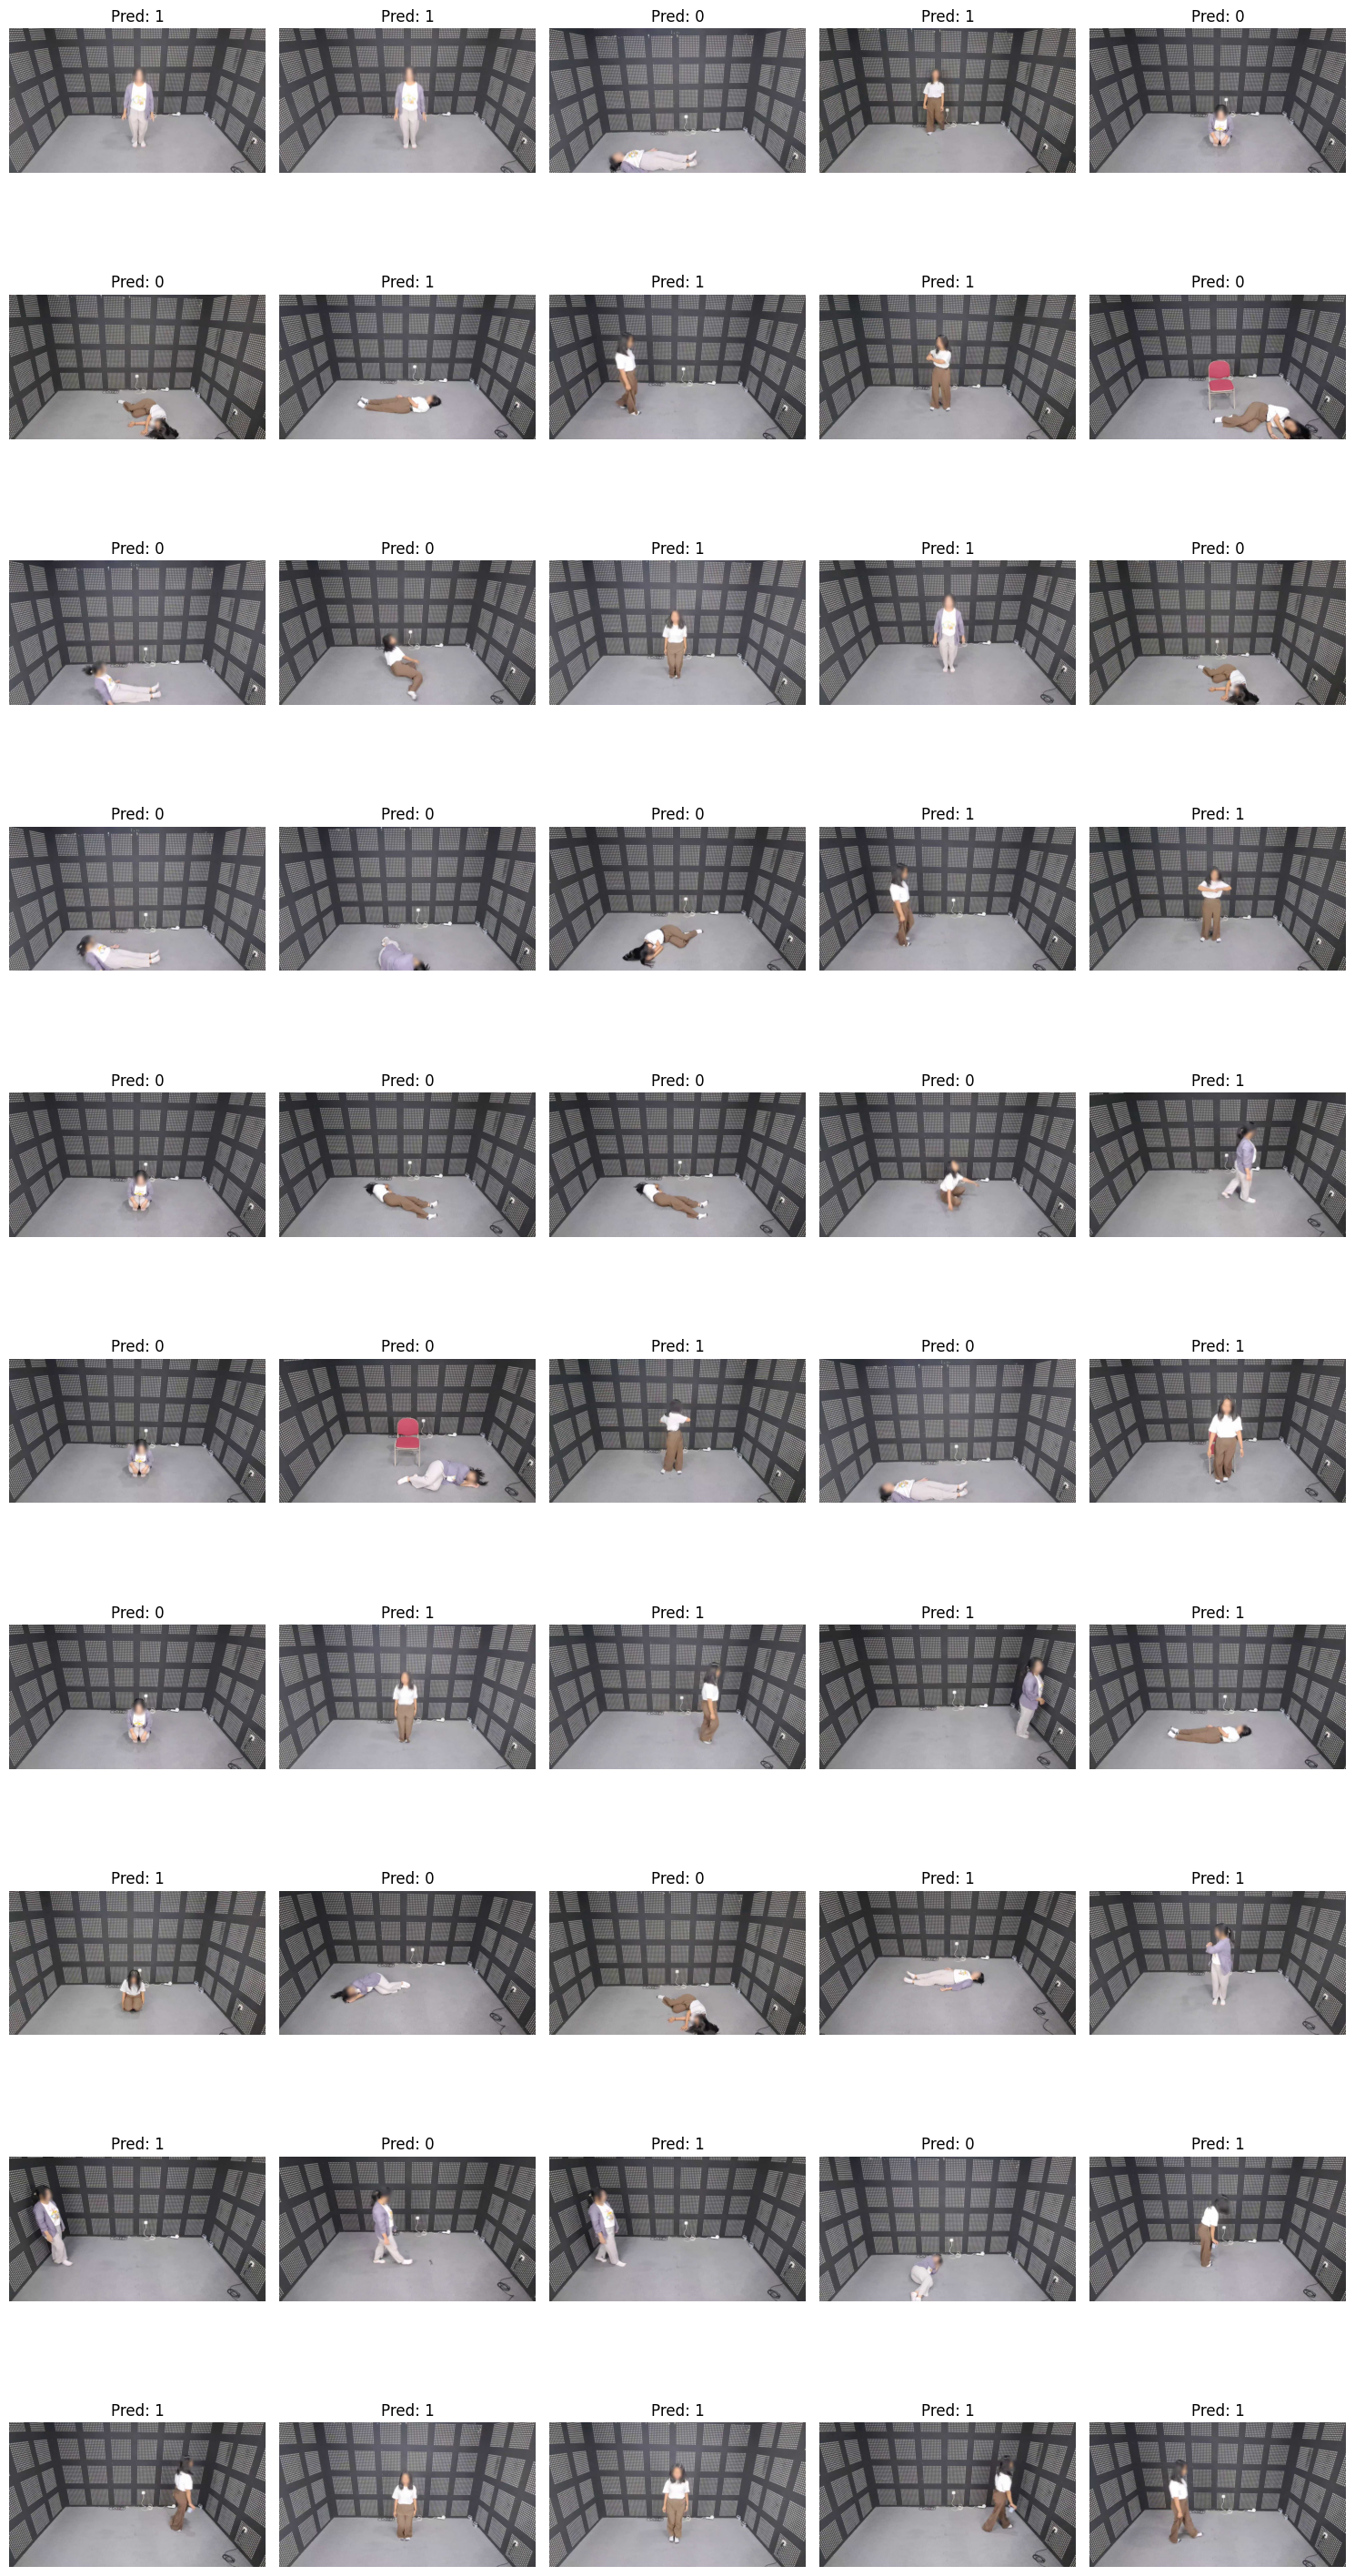

In [23]:
import matplotlib.pyplot as plt

def visualize_predictions(image_df, max_images=50, num_images_per_row=5):
    # Limit the number of images to visualize
    num_images = min(max_images, len(image_df))
    num_rows = (num_images + num_images_per_row - 1) // num_images_per_row  # Calculate number of rows needed

    plt.figure(figsize=(15, 3 * num_rows))  # Adjust figure size based on number of rows
    for i in range(num_images):
        img_path = image_df['filename'].iloc[i]
        img = Image.open(img_path).convert('RGB')
        plt.subplot(num_rows, num_images_per_row, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Pred: {image_df["predicted_label"].iloc[i]}')
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Visualize a subset of predictions (e.g., first 50 images)
visualize_predictions(image_df, max_images=50, num_images_per_row=5)

In [24]:
import os
import pandas as pd

# Create a new DataFrame with 'id' and 'label'
predictions_df = pd.DataFrame({
    'id': [os.path.basename(filename) for filename in image_df['filename']],
    'label': image_df['predicted_label']
})

# Save the predictions to a CSV file
predictions_df.to_csv('predictions 2.csv', index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv
